In [4]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/home/jadli/Bureau/BDAI2/Satellite_Super_Resulotion0")
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

from src.utils.config import CONFIG
from src.utils.data_loader import create_loaders

from src.models.models_architecture import SRCNN        
from src.utils.helper_functions import train_sr, test_sr, plot_sr_progress


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device : {device}")

# CONFIG FROM YAML 
data_root      = CONFIG["paths"]["output_root"]
batch_size     = CONFIG["training"]["batch_size"]
num_workers    = CONFIG["training"]["num_workers"]
use_aug        = CONFIG["training"].get("use_augmentation", True)

# HYPERPARAMS FROM CONFIG 
lr              = CONFIG["training"]["lr"]
weight_decay    = CONFIG["training"]["weight_decay"]
num_epochs      = CONFIG["training"]["epochs"]
step_size       = CONFIG["training"]["scheduler_step_size"]
gamma           = CONFIG["training"]["scheduler_gamma"]


# LOAD DATA 

train_loader, val_loader, test_loader = create_loaders(
    root=data_root,
    batch_size=batch_size,
    num_workers=num_workers,
    use_augmentation=use_aug
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device : cuda

📦 DATA LOADED:
  Train: 64800 samples
  Val:   8100 samples
  Test:  8100 samples


In [51]:
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [ ]:
train_losses, val_losses = [], []
train_psnrs,  val_psnrs  = [], []

best_psnr = 0.0
best_model_path = CONFIG["model"]["best_SRCNN_path"]
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)



for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_psnr = train_sr(
        model, train_loader, criterion,model_requires_upscale=True, optimizer, device, scheduler
    )
    val_loss, val_psnr = test_sr(
        model, val_loader,  criterion, model_requires_upscale=True, device
    )


    # save best model
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        torch.save(model.state_dict(), best_model_path)
        print(f"🔥 New best model saved with Val PSNR = {best_psnr:.2f} dB")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_psnrs.append(train_psnr)
    val_psnrs.append(val_psnr)

    print(f"Train loss: {train_loss:.6f} | Train PSNR: {train_psnr:.2f} dB")
    print(f"Val   loss: {val_loss:.6f} | Val   PSNR: {val_psnrs[-1]:.2f} dB")
    print(f"  ➤ LR: {optimizer.param_groups[0]['lr']:.8f}")


plot_sr_progress(train_losses, val_losses, train_psnrs, val_psnrs)


In [ ]:
model = SRCNN().to(device)
weights_path = CONFIG["model"]["best_SRCNN_path"]

assert os.path.exists(weights_path), f"❌ Model not found: {weights_path}"
print(f"✔ Loading model from {weights_path}")
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

✔ Loading model from src/models/checkpoints/best_srcnn.pth


/tmp/ipykernel_22928/4139380647.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [54]:
def load_image(path):
    return Image.open(path).convert("RGB")

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(1.0 / np.sqrt(mse))

In [55]:
def test_image(lr_path, hr_path, upscale=4, auto_resize=True):
    print("\n Testing on image:")
    print("  LR:", lr_path)
    print("  HR:", hr_path)

    lr = load_image(lr_path)
    hr = load_image(hr_path)

    # tensors
    lr_tensor = T.ToTensor()(lr).unsqueeze(0).to(device)
    hr_tensor = T.ToTensor()(hr).unsqueeze(0).to(device)

    # upscale LR
    lr_up = F.interpolate(lr_tensor, scale_factor=upscale,
                        mode="bicubic", align_corners=False)

    with torch.no_grad():
        sr_tensor = model(lr_up)

    # → numpy [H,W,C], [0,1]
    lr_up_img = lr_up.squeeze(0).permute(1, 2, 0).cpu().numpy()
    sr_img    = sr_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    hr_img    = hr_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # --- aligner les tailles si besoin ---
    if lr_up_img.shape != hr_img.shape:
        print(f"⚠ Size mismatch: lr_up={lr_up_img.shape}, hr={hr_img.shape}")
        if auto_resize:
            H, W = lr_up_img.shape[:2]
            hr_pil = Image.fromarray((hr_img * 255).astype(np.uint8))
            hr_resized = hr_pil.resize((W, H), Image.BICUBIC)
            hr_img = np.array(hr_resized).astype(np.float32) / 255.0
            print(f" HR resized to {hr_img.shape} for PSNR")
        else:
            print(" Cannot compute PSNR if sizes differ and auto_resize=False")
            return

    # PSNR
    psnr_bic   = psnr(lr_up_img, hr_img)
    psnr_srcnn = psnr(sr_img,    hr_img)

    print(f" PSNR Bicubic : {psnr_bic:.2f} dB")
    print(f" PSNR SRCNN   : {psnr_srcnn:.2f} dB")

    # --- affichage ---
    titles = ["LR Input", "Upscaled Bicubic", "SRCNN Output", "HR Ground Truth"]
    images = [
        lr,
        Image.fromarray((lr_up_img * 255).astype(np.uint8)),
        Image.fromarray((sr_img * 255).astype(np.uint8)),
        Image.fromarray((hr_img * 255).astype(np.uint8)),
    ]

    plt.figure(figsize=(14, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


 Testing on image:
  LR: data/preprocessed/test/LR/austin1_r01_c05.png
  HR: data/preprocessed/test/HR/austin1_r01_c05.png
 PSNR Bicubic : 20.02 dB
 PSNR SRCNN   : 19.40 dB


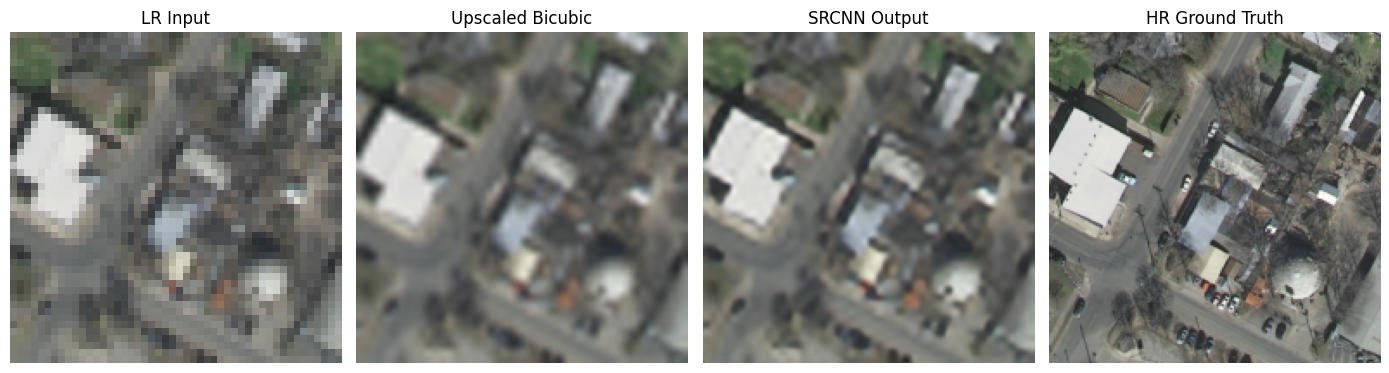

In [22]:
test_image(
    "data/preprocessed/test/LR/austin1_r01_c05.png",
    "data/preprocessed/test/HR/austin1_r01_c05.png",
    upscale=4
)
